In [200]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [111]:
root_path = './dataset/'

In [112]:
comportamiento_df = pd.read_csv(f'{root_path}comportamiento_tarjetasvisa.csv', sep = ',')

In [113]:
informacion_df = pd.read_csv(f'{root_path}informacion_adicional_tarjetas.csv', sep = ',')

In [114]:
comportamiento_df['ID_CLIENTE'].value_counts().shape[0]

45985

### Definición de mal pagador

In [115]:
comportamiento_df.drop_duplicates()
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS
0,5001711,0,NaN
1,5001711,-1,11.0
2,5001711,-2,16.0
3,5001711,-3,16.0
4,5001712,0,0.0
...,...,...,...
1048570,5150487,-25,0.0
1048571,5150487,-26,0.0
1048572,5150487,-27,0.0
1048573,5150487,-28,0.0


In [116]:
comportamiento_df.isnull().sum()

ID_CLIENTE            0
MESES                 0
DIAS_VENCIDOS    209230
dtype: int64

##### 20% de las observaciones son nulas en columna DIAS_VENCIDOS

In [117]:
grupo_df = comportamiento_df.groupby(["ID_CLIENTE","MESES"]).max()
grupo_df

DIAS_VENCIDOS
ID_CLIENTE MESES               
5001711    -3              16.0
           -2              16.0
           -1              11.0
            0               NaN
5001712    -18             17.0
...                         ...
5150487    -4               0.0
           -3               0.0
           -2               0.0
           -1               0.0
            0               0.0

[1048575 rows x 1 columns]

In [118]:
filtro_nulos = comportamiento_df.groupby('ID_CLIENTE').filter(lambda x:x['DIAS_VENCIDOS'].isnull().any())
filtro_nulos['ID_CLIENTE'].value_counts().shape[0]

25005

In [119]:
comportamiento_df['ID_CLIENTE'].value_counts().shape[0]

45985

##### De un total de 45,985 clientes con comportamiento del manejo de tarjeta, 25,005 clientes tienen al menos un campo nulo en dias vencidos.

##### Se consideran todas las observaciones para definir el tipo de pagador toda vez que podemos asegurar un mal comportamiento con información cierta.

##### Score de comportamiento:
Mayor que 25 y menor igual que 30, se puntúa el comportamiento con 0.25.
Mayor que 30, se puntúa con 1.

In [120]:
# funcion para score comportamiento
def score_comportamiento(dias_vencidos):
    if dias_vencidos > 25 and dias_vencidos <= 30:
        return 0.25
    elif dias_vencidos > 30:
        return 1
    else:
        return 0

In [121]:
comportamiento_df['SCORE'] = comportamiento_df['DIAS_VENCIDOS'].apply(score_comportamiento)
comportamiento_df['MESES_ANTIGUEDAD'] = (comportamiento_df.groupby('ID_CLIENTE')['MESES'].transform('min')) * (-1)
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS,SCORE,MESES_ANTIGUEDAD
0,5001711,0,NaN,0.0,3
1,5001711,-1,11.0,0.0,3
2,5001711,-2,16.0,0.0,3
3,5001711,-3,16.0,0.0,3
4,5001712,0,0.0,0.0,18
...,...,...,...,...,...
1048570,5150487,-25,0.0,0.0,29
1048571,5150487,-26,0.0,0.0,29
1048572,5150487,-27,0.0,0.0,29
1048573,5150487,-28,0.0,0.0,29


In [122]:
calificacion_df = comportamiento_df[["ID_CLIENTE","MESES_ANTIGUEDAD","SCORE"]].groupby(["ID_CLIENTE","MESES_ANTIGUEDAD"]).sum().reset_index()
calificacion_df

,ID_CLIENTE,MESES_ANTIGUEDAD,SCORE
0,5001711,3,0.00
1,5001712,18,0.25
2,5001713,21,0.00
3,5001714,14,0.00
4,5001715,59,0.00
...,...,...,...
45980,5150482,28,0.25
45981,5150483,17,0.00
45982,5150484,12,0.50
45983,5150485,1,0.25


In [123]:
# definir etiqueta de mal pagador
def tipo_cliente(meses_antiguedad, score_total):
    if meses_antiguedad <= 6 and score_total > 0:
        return 'mal pagador'
    elif meses_antiguedad > 6 and meses_antiguedad <= 12 and score_total > 0.5:
        return 'mal pagador'
    elif meses_antiguedad > 12 and meses_antiguedad <= 24 and score_total >= 1.5:
        return 'mal pagador'
    elif meses_antiguedad > 24 and meses_antiguedad <= 36 and score_total >= 2.5:
        return 'mal pagador'
    elif meses_antiguedad > 36 and meses_antiguedad <= 48 and score_total >= 3.5:
        return 'mal pagador'
    elif meses_antiguedad > 48 and meses_antiguedad <= 60 and score_total >= 4.5:
        return 'mal pagador'
    elif meses_antiguedad > 60 and score_total >= 5.5:
        return 'mal pagador'
    else:
        return 'buen pagador'

In [124]:
calificacion_df['TIPO_CLIENTE'] = calificacion_df.apply(lambda x: tipo_cliente(x['MESES_ANTIGUEDAD'], x['SCORE']), axis=1)
calificacion_df['TIPO_CLIENTE'].value_counts(normalize=True)

TIPO_CLIENTE
buen pagador    0.907426
mal pagador     0.092574
Name: proportion, dtype: float64

### Join con información adicional del cliente

In [125]:
calificacion_df.isnull().sum()

ID_CLIENTE          0
MESES_ANTIGUEDAD    0
SCORE               0
TIPO_CLIENTE        0
dtype: int64

In [126]:
calificacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_CLIENTE        45985 non-null  int64  
 1   MESES_ANTIGUEDAD  45985 non-null  int64  
 2   SCORE             45985 non-null  float64
 3   TIPO_CLIENTE      45985 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


No se tiene valores nulos con el nuevo dataset con la definición de mal pagador

In [127]:
#Se crea un nuevo data con las dos columnas solicitadas CLIENTE_ID (ID_CLIENTE) y mal_pagador (TIPO_CLIENTE)
definicion_df = calificacion_df[["ID_CLIENTE", "TIPO_CLIENTE"]]
definicion_df

,ID_CLIENTE,TIPO_CLIENTE
0,5001711,buen pagador
1,5001712,buen pagador
2,5001713,buen pagador
3,5001714,buen pagador
4,5001715,buen pagador
...,...,...
45980,5150482,buen pagador
45981,5150483,buen pagador
45982,5150484,buen pagador
45983,5150485,mal pagador


In [128]:
#Análisis del dataset con la información de los clientes
informacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438557 non-null  int64  
 1   GENERO                      438557 non-null  object 
 2   TIENE_CARRO                 438557 non-null  int64  
 3   TIENE_PROPIEDADES           438557 non-null  int64  
 4   N_NINOS                     438557 non-null  int64  
 5   INGRESO_ANUAL               438557 non-null  float64
 6   CATEGORIA_INGRESO           438557 non-null  object 
 7   NIVEL_EDUCACION             438557 non-null  object 
 8   ESTADO_CIVIL                438557 non-null  object 
 9   TIPO_CASA                   438557 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438557 non-null  int64  
 11  DIAS_TRABAJANDO             438557 non-null  int64  
 12  TIENE_CELULAR               438557 non-null  int64  
 13  TIENE_NUMEROTE

In [129]:
informacion_df.drop_duplicates()
informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [130]:
informacion_df.isnull().sum()

ID_CLIENTE                         0
GENERO                             0
TIENE_CARRO                        0
TIENE_PROPIEDADES                  0
N_NINOS                            0
INGRESO_ANUAL                      0
CATEGORIA_INGRESO                  0
NIVEL_EDUCACION                    0
ESTADO_CIVIL                       0
TIPO_CASA                          0
DIAS_DESDE_NACIMIENTO              0
DIAS_TRABAJANDO                    0
TIENE_CELULAR                      0
TIENE_NUMEROTELEF_LABORAL          0
TIENE_NUMEROTELEF_PERSONAL         0
TIENE_EMAIL                        0
PROFESION                     134203
N_MIEMBROSFAMILIA                  0
dtype: int64

##### El 31% de las observaciones para la información de las tarjetas es nula en la descripción de la profesión

In [131]:
id_informacion_df = informacion_df["ID_CLIENTE"].value_counts()
id_informacion_df

ID_CLIENTE
7702516    2
7602432    2
7836971    2
7213374    2
7052783    2
          ..
6840104    1
6840222    1
6841878    1
6842765    1
5008808    1
Name: count, Length: 438510, dtype: int64

In [132]:
#Observando los valores repetidos
repetido_informacion_df = id_informacion_df[id_informacion_df > 1].index
repetido_informacion_df

Index([7702516, 7602432, 7836971, 7213374, 7052783, 7023651, 7838075, 7636389,
       7052812, 7372589, 7155150, 7090931, 7091721, 7137299, 7744386, 7772847,
       7636756, 7317997, 7053557, 7742853, 7576316, 7099881, 7046068, 7036518,
       7742298, 7022197, 7603224, 7023108, 7089090, 7702238, 7243768, 7045885,
       7836711, 7743418, 7045794, 7618285, 7207977, 7154598, 7154819, 7024111,
       7282535, 7050948, 7416167, 7174719, 7833087, 7135270, 7022327],
      dtype='int64', name='ID_CLIENTE')

In [133]:
repetido_filtro_df = informacion_df[informacion_df['ID_CLIENTE'].isin(repetido_informacion_df)].sort_values(by="ID_CLIENTE")
repetido_filtro_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
425023,7022197,F,0,1,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
426818,7022197,M,1,1,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
431911,7022327,M,1,1,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
431545,7022327,F,0,1,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
425486,7023108,M,1,1,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,0,1,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
428620,7836971,F,0,1,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
421464,7836971,M,1,0,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
422068,7838075,M,0,1,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


Se descartan los ids que tienen más de una información porque los valores cambiantes no siguen ningún patrón (MCAR)

In [134]:
#Obteniedo los id con información única
filtered_informacion_df = id_informacion_df[id_informacion_df == 1].index
filtered_informacion_df

Index([5008855, 5008856, 5008857, 5008858, 5008859, 5008860, 5008861, 5008862,
       5008863, 5008864,
       ...
       6839917, 6839936, 6840098, 6840100, 6840102, 6840104, 6840222, 6841878,
       6842765, 5008808],
      dtype='int64', name='ID_CLIENTE', length=438463)

In [135]:
#Filtrando los ids únicos
unicos_informacion_df = informacion_df[informacion_df['ID_CLIENTE'].isin(filtered_informacion_df)]
unicos_informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


94 registros se han descartado de la información de clientes

In [136]:
unificado_df = unicos_informacion_df.merge(definicion_df, how="left", on="ID_CLIENTE")
unificado_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,buen pagador
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438458,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438459,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438460,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438461,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


In [137]:
#Analizando la información unificada
unificado_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438463 entries, 0 to 438462
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438463 non-null  int64  
 1   GENERO                      438463 non-null  object 
 2   TIENE_CARRO                 438463 non-null  int64  
 3   TIENE_PROPIEDADES           438463 non-null  int64  
 4   N_NINOS                     438463 non-null  int64  
 5   INGRESO_ANUAL               438463 non-null  float64
 6   CATEGORIA_INGRESO           438463 non-null  object 
 7   NIVEL_EDUCACION             438463 non-null  object 
 8   ESTADO_CIVIL                438463 non-null  object 
 9   TIPO_CASA                   438463 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438463 non-null  int64  
 11  DIAS_TRABAJANDO             438463 non-null  int64  
 12  TIENE_CELULAR               438463 non-null  int64  
 13  TIENE_NUMEROTE

Hay 402006 registros lo que representa el 91 % de información nula porque los ids de clientes no estaban en la definición del tipo de cliente.
Es un categoría necesaria para analizar el tipo de cliente se va a trabajar con clientes que si estén categorizados

In [138]:
unificado_df[unificado_df.duplicated() == True]

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE


No se tiene valores duplicados ya que desde el inicio se usó la función drop_duplicates para no trabajar con valores repetidos

In [139]:
#Se conservan los registros que no tienen valores nulos para el tipo de cliente según la definición de mal pagador
clientes_df = unificado_df[unificado_df["TIPO_CLIENTE"].isnull() == False]
clientes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 434718
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID_CLIENTE                  36457 non-null  int64  
 1   GENERO                      36457 non-null  object 
 2   TIENE_CARRO                 36457 non-null  int64  
 3   TIENE_PROPIEDADES           36457 non-null  int64  
 4   N_NINOS                     36457 non-null  int64  
 5   INGRESO_ANUAL               36457 non-null  float64
 6   CATEGORIA_INGRESO           36457 non-null  object 
 7   NIVEL_EDUCACION             36457 non-null  object 
 8   ESTADO_CIVIL                36457 non-null  object 
 9   TIPO_CASA                   36457 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       36457 non-null  int64  
 11  DIAS_TRABAJANDO             36457 non-null  int64  
 12  TIENE_CELULAR               36457 non-null  int64  
 13  TIENE_NUMEROTELEF_LABORAL   36457 n

In [140]:
clientes_df[["TIPO_CLIENTE", "ID_CLIENTE"]].groupby("TIPO_CLIENTE").count()

,ID_CLIENTE
TIPO_CLIENTE,
buen pagador,32959
mal pagador,3498


### Data quality

El 31% de la información que se ha recolectado del cliente no ha indicado su profesión.

In [141]:
segun_genero_df = clientes_df[["GENERO", "PROFESION", "ID_CLIENTE"]].groupby("GENERO").count()
segun_genero_df

,PROFESION,ID_CLIENTE
GENERO,,
F,15630,24430
M,9504,12027


In [142]:
segun_genero_df["SIN PROFESION"] = segun_genero_df["ID_CLIENTE"] - segun_genero_df["PROFESION"]
segun_genero_df["% SIN PROFESION"] = (segun_genero_df["SIN PROFESION"] * 100)/segun_genero_df["ID_CLIENTE"]
segun_genero_df

,PROFESION,ID_CLIENTE,SIN PROFESION,% SIN PROFESION
GENERO,,,,
F,15630,24430,8800,36.021285
M,9504,12027,2523,20.977800


In [143]:
clientes_df.isnull().sum()/clientes_df.shape[0]


ID_CLIENTE                    0.000000
GENERO                        0.000000
TIENE_CARRO                   0.000000
TIENE_PROPIEDADES             0.000000
N_NINOS                       0.000000
INGRESO_ANUAL                 0.000000
CATEGORIA_INGRESO             0.000000
NIVEL_EDUCACION               0.000000
ESTADO_CIVIL                  0.000000
TIPO_CASA                     0.000000
DIAS_DESDE_NACIMIENTO         0.000000
DIAS_TRABAJANDO               0.000000
TIENE_CELULAR                 0.000000
TIENE_NUMEROTELEF_LABORAL     0.000000
TIENE_NUMEROTELEF_PERSONAL    0.000000
TIENE_EMAIL                   0.000000
PROFESION                     0.310585
N_MIEMBROSFAMILIA             0.000000
TIPO_CLIENTE                  0.000000
dtype: float64

El 36 % de mujeres no ha indicado que profesión tienen y el 21% de los hombres prefirieron no decir a que se dedican

### Feature transformation

In [144]:
clientes_df.describe()

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA
count,3.645700e+04,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.379708,0.672189,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,0.485321,0.469422,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.000000,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [145]:
fecha_fijada = datetime(2024, 6, 29).date()
clientes_df['FECHA_NACIMIENTO'] = clientes_df['DIAS_DESDE_NACIMIENTO'].apply(lambda x: fecha_fijada + timedelta(days=x))
clientes_df['ANIO_NACIMIENTO'] = clientes_df['FECHA_NACIMIENTO'].apply(lambda x: x.year)
clientes_df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11624\3620495674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['FECHA_NACIMIENTO'] = clientes_df['DIAS_DESDE_NACIMIENTO'].apply(lambda x: fecha_fijada + timedelta(days=x))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11624\3620495674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['ANIO_NACIMIENTO'] = clientes_df['FECHA_NACIMIENTO'].apply(lambda x: x.year)


,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,buen pagador,1965-09-13,1965
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,mal pagador,1976-12-30,1976
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990
434716,5149838,F,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,mal pagador,1975-04-30,1975


In [146]:
#funcion para etiqueta generacional
def generacion(anio_nacimiento):
    if anio_nacimiento >= 1997:
        return 'Generación Z'
    elif 1981 <= anio_nacimiento < 1997:
        return 'Millennials'
    elif 1965 <= anio_nacimiento < 1981:
        return 'Generación X'
    elif 1946 <= anio_nacimiento < 1965:
        return 'Baby Boomers'
    else:
        return 'Generación Silenciosa'
clientes_df['GENERACION'] = clientes_df['ANIO_NACIMIENTO'].apply(generacion)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11624\2287765963.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['GENERACION'] = clientes_df['ANIO_NACIMIENTO'].apply(generacion)


In [147]:
clientes_df['GENERACION'].value_counts()

GENERACION
Millennials     16690
Generación X    13209
Baby Boomers     4233
Generación Z     2325
Name: count, dtype: int64

In [148]:
clientes_df.isnull().sum()/clientes_df.shape[0]


ID_CLIENTE                    0.000000
GENERO                        0.000000
TIENE_CARRO                   0.000000
TIENE_PROPIEDADES             0.000000
N_NINOS                       0.000000
INGRESO_ANUAL                 0.000000
CATEGORIA_INGRESO             0.000000
NIVEL_EDUCACION               0.000000
ESTADO_CIVIL                  0.000000
TIPO_CASA                     0.000000
DIAS_DESDE_NACIMIENTO         0.000000
DIAS_TRABAJANDO               0.000000
TIENE_CELULAR                 0.000000
TIENE_NUMEROTELEF_LABORAL     0.000000
TIENE_NUMEROTELEF_PERSONAL    0.000000
TIENE_EMAIL                   0.000000
PROFESION                     0.310585
N_MIEMBROSFAMILIA             0.000000
TIPO_CLIENTE                  0.000000
FECHA_NACIMIENTO              0.000000
ANIO_NACIMIENTO               0.000000
GENERACION                    0.000000
dtype: float64

### Análisis descriptivo

In [162]:
generacion_df = pd.crosstab(clientes_df['GENERACION'], clientes_df["TIPO_CLIENTE"], normalize="index")
generacion_df

TIPO_CLIENTE,buen pagador,mal pagador
GENERACION,,
Baby Boomers,0.910702,0.089298
Generación X,0.909380,0.090620
Generación Z,0.872688,0.127312
Millennials,0.902516,0.097484


In [150]:
generacion_df.reindex(["Generación Z", "Millennials", "Generación X", "Baby Boomers"])

TIPO_CLIENTE,buen pagador,mal pagador
GENERACION,,
Generación Z,0.872688,0.127312
Millennials,0.902516,0.097484
Generación X,0.909380,0.090620
Baby Boomers,0.910702,0.089298


### Análisis correlacional 

In [151]:
clientes_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO,GENERACION
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991,Millennials
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991,Millennials
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,buen pagador,1965-09-13,1965,Generación X
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Managers,2.0,mal pagador,1976-12-30,1976,Generación X
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials
434716,5149838,F,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Sales staff,2.0,mal pagador,1975-04-30,1975,Generación X


In [152]:
clientes_df.isnull().sum()/clientes_df.shape[0]


ID_CLIENTE                    0.000000
GENERO                        0.000000
TIENE_CARRO                   0.000000
TIENE_PROPIEDADES             0.000000
N_NINOS                       0.000000
INGRESO_ANUAL                 0.000000
CATEGORIA_INGRESO             0.000000
NIVEL_EDUCACION               0.000000
ESTADO_CIVIL                  0.000000
TIPO_CASA                     0.000000
DIAS_DESDE_NACIMIENTO         0.000000
DIAS_TRABAJANDO               0.000000
TIENE_CELULAR                 0.000000
TIENE_NUMEROTELEF_LABORAL     0.000000
TIENE_NUMEROTELEF_PERSONAL    0.000000
TIENE_EMAIL                   0.000000
PROFESION                     0.310585
N_MIEMBROSFAMILIA             0.000000
TIPO_CLIENTE                  0.000000
FECHA_NACIMIENTO              0.000000
ANIO_NACIMIENTO               0.000000
GENERACION                    0.000000
dtype: float64

In [153]:
clientes_df["TIPO_CLIENTE"].value_counts()

TIPO_CLIENTE
buen pagador    32959
mal pagador      3498
Name: count, dtype: int64

In [154]:
clientes_df.dtypes

ID_CLIENTE                      int64
GENERO                         object
TIENE_CARRO                     int64
TIENE_PROPIEDADES               int64
N_NINOS                         int64
INGRESO_ANUAL                 float64
CATEGORIA_INGRESO              object
NIVEL_EDUCACION                object
ESTADO_CIVIL                   object
TIPO_CASA                      object
DIAS_DESDE_NACIMIENTO           int64
DIAS_TRABAJANDO                 int64
TIENE_CELULAR                   int64
TIENE_NUMEROTELEF_LABORAL       int64
TIENE_NUMEROTELEF_PERSONAL      int64
TIENE_EMAIL                     int64
PROFESION                      object
N_MIEMBROSFAMILIA             float64
TIPO_CLIENTE                   object
FECHA_NACIMIENTO               object
ANIO_NACIMIENTO                 int64
GENERACION                     object
dtype: object

In [155]:
## no aparece la columna TIPO_CLIENTE porque no es un valor numérico 
correlation_matrix=clientes_df.corr(numeric_only=True)
correlation_matrix

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA,ANIO_NACIMIENTO
ID_CLIENTE,1.000000,-0.011163,-0.098851,0.028878,-0.017667,0.056016,-0.038043,NaN,0.079215,0.009879,-0.046979,0.026624,0.055861
TIENE_CARRO,-0.011163,1.000000,-0.015185,0.105839,0.215506,0.157144,-0.156452,NaN,0.021644,-0.014019,0.021750,0.151814,0.156806
TIENE_PROPIEDADES,-0.098851,-0.015185,1.000000,-0.000575,0.032719,-0.129838,0.093006,NaN,-0.207732,-0.066601,0.052194,-0.005723,-0.130361
N_NINOS,0.028878,0.105839,-0.000575,1.000000,0.033691,0.339357,-0.229379,NaN,0.048091,-0.016291,0.015960,0.889114,0.339087
INGRESO_ANUAL,-0.017667,0.215506,0.032719,0.033691,1.000000,0.067908,-0.168611,NaN,-0.037746,0.017245,0.086681,0.023750,0.067684
DIAS_DESDE_NACIMIENTO,0.056016,0.157144,-0.129838,0.339357,0.067908,1.000000,-0.616213,NaN,0.179054,-0.028659,0.105625,0.304020,0.999681
DIAS_TRABAJANDO,-0.038043,-0.156452,0.093006,-0.229379,-0.168611,-0.616213,1.000000,NaN,-0.242869,-0.007233,-0.085648,-0.221241,-0.616058
TIENE_CELULAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIENE_NUMEROTELEF_LABORAL,0.079215,0.021644,-0.207732,0.048091,-0.037746,0.179054,-0.242869,NaN,1.000000,0.311644,-0.034838,0.064527,0.179013
TIENE_NUMEROTELEF_PERSONAL,0.009879,-0.014019,-0.066601,-0.016291,0.017245,-0.028659,-0.007233,NaN,0.311644,1.000000,0.010455,-0.004221,-0.028332


In [156]:
def conversion_tipo_cliente (tipo_cliente):
    if tipo_cliente == "buen pagador": 
        return 1
    else:
        return 0

In [157]:
clientes_df['NUM_TIPO_CLIENTE'] = clientes_df.apply(lambda x: conversion_tipo_cliente(x["TIPO_CLIENTE"]), axis=1)
correlation_matrix = clientes_df.corr(numeric_only=True)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11624\459550570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['NUM_TIPO_CLIENTE'] = clientes_df.apply(lambda x: conversion_tipo_cliente(x["TIPO_CLIENTE"]), axis=1)


In [158]:
#df_encoded = pd.get_dummies(clientes_df)
#correlation_matrix = df_encoded.corr()
#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')


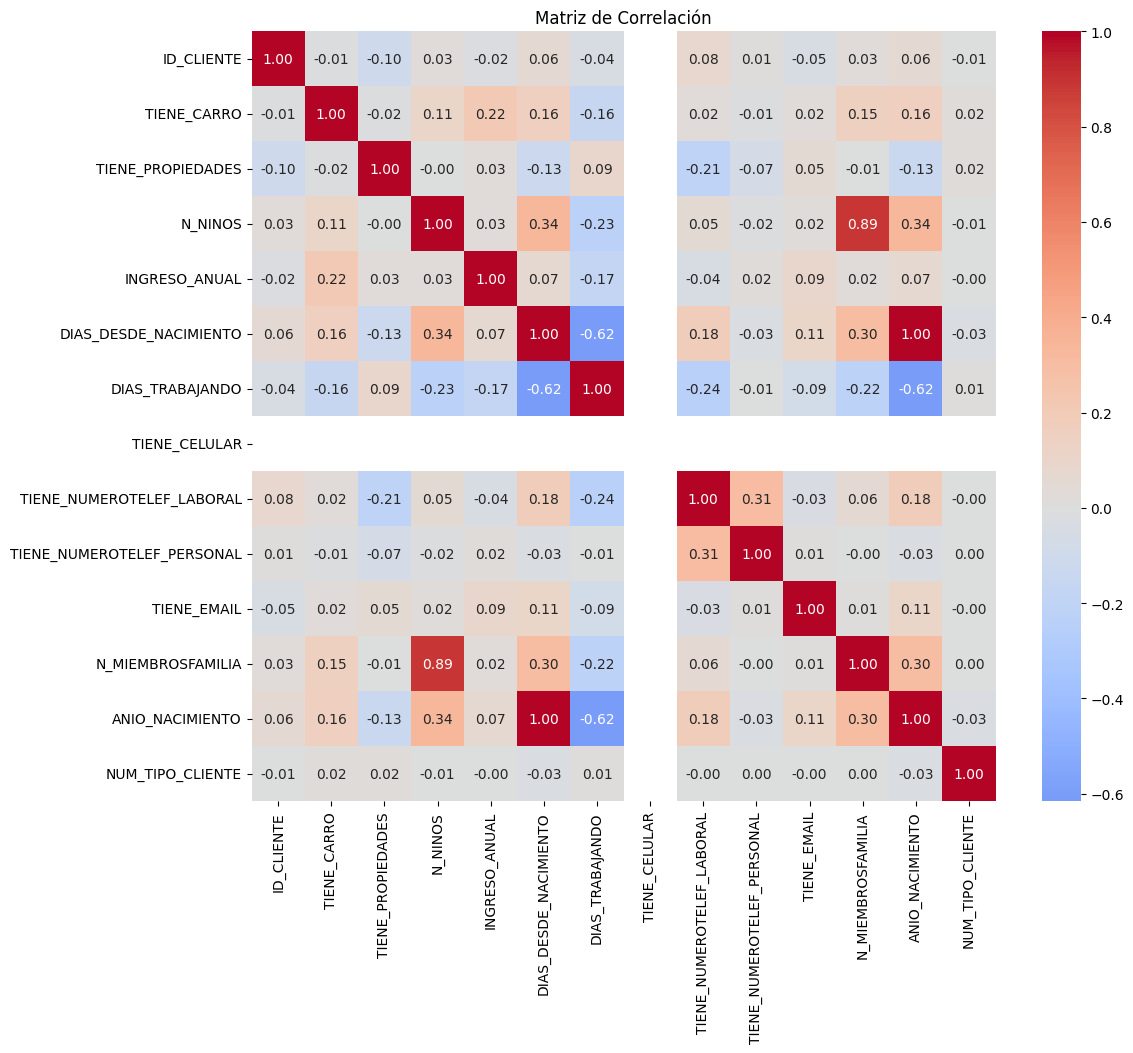

In [159]:
## con figsize ajustamos el tamano de los cuadros de la matriz
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [160]:
clientes_df["INGRESO_ANUAL"].describe().astype(int)

count      36457
mean      186685
std       101789
min        27000
25%       121500
50%       157500
75%       225000
max      1575000
Name: INGRESO_ANUAL, dtype: int64

In [161]:
clientes_df["NIVEL_EDUCACION"].value_counts()

NIVEL_EDUCACION
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: count, dtype: int64

In [205]:
## correlacion nivel de educacion vs tipo cliente
educacion_df = pd.crosstab(clientes_df['NIVEL_EDUCACION'], clientes_df["TIPO_CLIENTE"], normalize="index")
educacion_df

TIPO_CLIENTE,buen pagador,mal pagador
NIVEL_EDUCACION,,
Academic degree,0.968750,0.031250
Higher education,0.909165,0.090835
Incomplete higher,0.887943,0.112057
Lower secondary,0.898396,0.101604
Secondary / secondary special,0.902934,0.097066


In [166]:
educacion_df.reindex(["Academic degree", "Higher education", "Secondary / secondary special", "Lower secondary", "Incomplete higher"])


TIPO_CLIENTE,buen pagador,mal pagador
NIVEL_EDUCACION,,
Academic degree,0.968750,0.031250
Higher education,0.909165,0.090835
Secondary / secondary special,0.902934,0.097066
Lower secondary,0.898396,0.101604
Incomplete higher,0.887943,0.112057


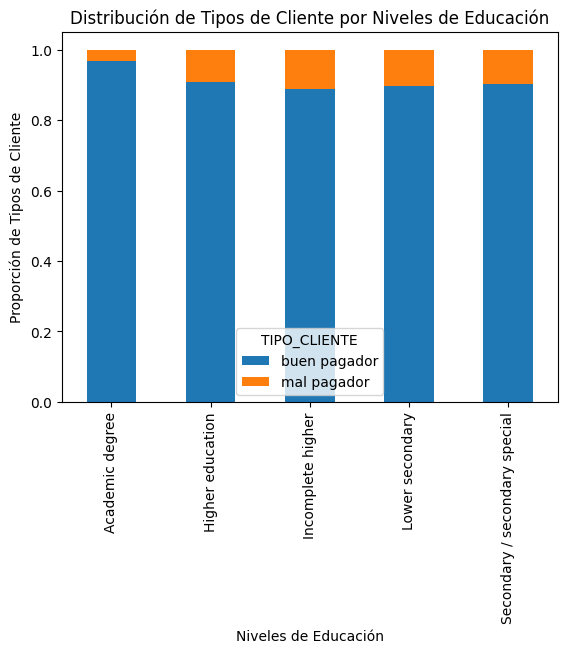

In [203]:
educacion_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Educación')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Educación')
plt.show()

In [168]:
clientes_df["INGRESO_ANUAL"].max()

np.float64(1575000.0)

In [170]:
clientes_df["INGRESO_ANUAL"].min()

np.float64(27000.0)

In [175]:
#se tendran tres rangos de ingresos 
resta_ingresos_df = (clientes_df["INGRESO_ANUAL"].max())-(clientes_df["INGRESO_ANUAL"].min())
resta_ingresos_df/3

np.float64(516000.0)

In [190]:
def rangos_ingresos(ingresos_anuales):
    if ingresos_anuales <= (27000 + 516000):
        return "Ingresos bajos"
    elif ingresos_anuales >= (1575000 - 516000):
        return "Ingresos altos"
    else:
        return "Ingresos medios"
    
clientes_df["NIVEL_INGRESOS"] = clientes_df["INGRESO_ANUAL"].apply(rangos_ingresos)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11624\3384499526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df["NIVEL_INGRESOS"] = clientes_df["INGRESO_ANUAL"].apply(rangos_ingresos)


In [191]:
clientes_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO,GENERACION,NUM_TIPO_CLIENTE,NIVEL_INGRESOS
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,NaN,2.0,buen pagador,1991-08-17,1991,Millennials,1,Ingresos bajos
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,NaN,2.0,buen pagador,1991-08-17,1991,Millennials,1,Ingresos bajos
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Security staff,2.0,buen pagador,1965-09-13,1965,Generación X,1,Ingresos bajos
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X,1,Ingresos bajos
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X,1,Ingresos bajos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Managers,2.0,mal pagador,1976-12-30,1976,Generación X,0,Ingresos bajos
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials,0,Ingresos bajos
434716,5149838,F,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials,0,Ingresos bajos
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Sales staff,2.0,mal pagador,1975-04-30,1975,Generación X,0,Ingresos bajos


In [193]:
clientes_df["NIVEL_INGRESOS"].value_counts()

NIVEL_INGRESOS
Ingresos bajos     36082
Ingresos medios      358
Ingresos altos        17
Name: count, dtype: int64

In [197]:
ingresos_df = pd.crosstab(clientes_df["NIVEL_INGRESOS"], clientes_df["TIPO_CLIENTE"], normalize="index")
ingresos_df

TIPO_CLIENTE,buen pagador,mal pagador
NIVEL_INGRESOS,,
Ingresos altos,0.529412,0.470588
Ingresos bajos,0.904274,0.095726
Ingresos medios,0.899441,0.100559


In [198]:
ingresos_df.reindex(["Ingresos bajos", "Ingresos medios", "Ingresos altos"])

TIPO_CLIENTE,buen pagador,mal pagador
NIVEL_INGRESOS,,
Ingresos bajos,0.904274,0.095726
Ingresos medios,0.899441,0.100559
Ingresos altos,0.529412,0.470588


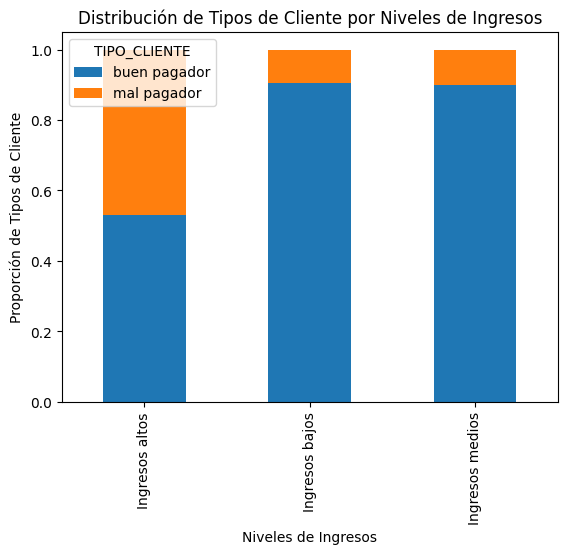

In [201]:
ingresos_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Ingresos')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Ingresos')
plt.show()


In [208]:
union_df = pd.crosstab([clientes_df["NIVEL_INGRESOS"], clientes_df["NIVEL_EDUCACION"]] , clientes_df["TIPO_CLIENTE"], normalize="index")
union_df



TIPO_CLIENTE                                   buen pagador  mal pagador
NIVEL_INGRESOS  NIVEL_EDUCACION                                         
Ingresos altos  Higher education                   0.562500     0.437500
                Secondary / secondary special      0.000000     1.000000
Ingresos bajos  Academic degree                    0.968750     0.031250
                Higher education                   0.910268     0.089732
                Incomplete higher                  0.885673     0.114327
                Lower secondary                    0.898396     0.101604
                Secondary / secondary special      0.902974     0.097026
Ingresos medios Higher education                   0.883249     0.116751
                Incomplete higher                  1.000000     0.000000
                Secondary / secondary special      0.902256     0.097744

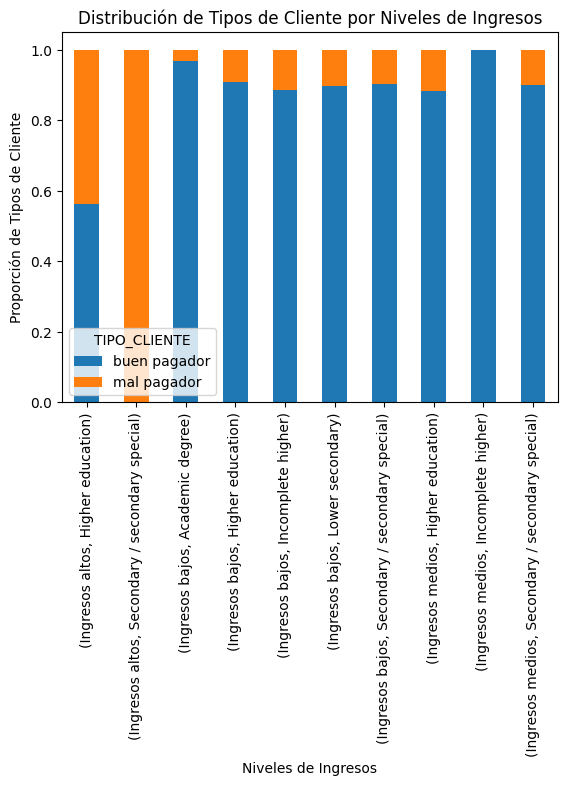

In [209]:
union_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Ingresos')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Ingresos')
plt.show()